In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

/tmp/ipykernel_10793/2301828658.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('ice_cream.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [3]:
df.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [4]:
df['date'] = pd.to_datetime(df.date)
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [5]:
df.set_index('date', inplace=True)
df.head()

,production
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
start_date = pd.to_datetime('2010-01-01')
df = df[start_date:]
df.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


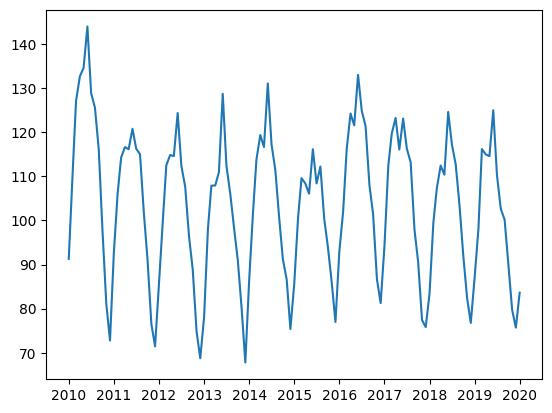

In [7]:
plt.plot(df.production)
plt.show()

# ACF

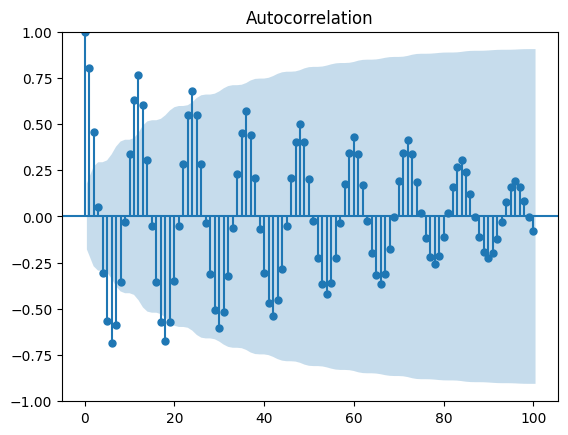

In [8]:
acf_plot = plot_acf(df.production, lags=100)

#### Based on decaying PCF we are likely dealing with Auto Regressive model

# PACF

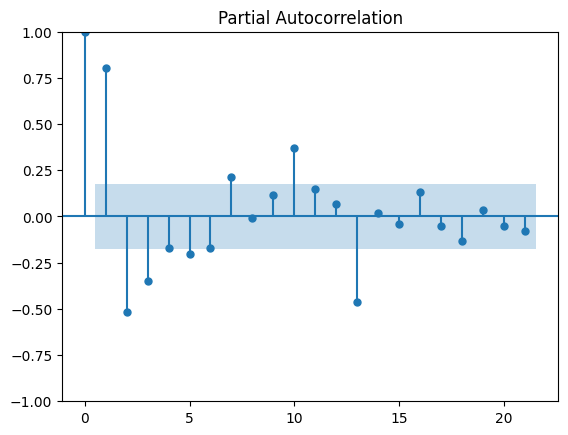

In [9]:
pacf_plot = plot_pacf(df.production)

#### Based on PACF, we can start an auto-regressive model based on 1,2,3,10 and 13

# Stock Data

In [10]:
# Getting stocks data
import yfinance as yf
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2015-1-1', end='2020-1-1')
tickerDf = tickerDf[['Close']]
tickerDf.head()

/media/crsdvaibhav/New Volume/notes/finance/time-series/env/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Close
Date,
2015-01-02 00:00:00-05:00,174.806778
2015-01-05 00:00:00-05:00,171.649796
2015-01-06 00:00:00-05:00,170.033081
2015-01-07 00:00:00-05:00,172.151871
2015-01-08 00:00:00-05:00,175.206711


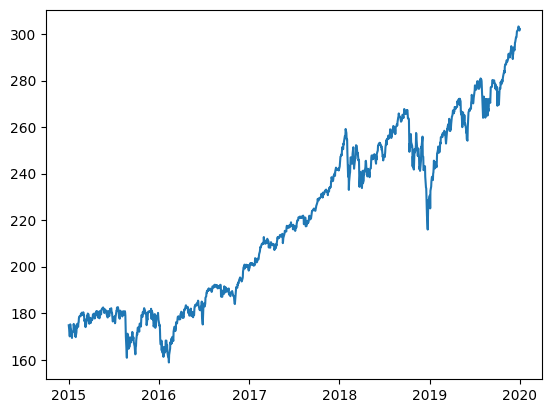

In [11]:
plt.plot(tickerDf.Close)
plt.show()

#### This is not stationary and is increasing, so we can plot first difference of this series, which is the price on this day minus the stock price on the previous day

In [12]:
first_diffs = tickerDf.Close.values[1:] - tickerDf.Close.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])
tickerDf['FirstDifference'] = first_diffs
tickerDf.head()

,Close,FirstDifference
Date,,
2015-01-02 00:00:00-05:00,174.806778,-3.156982
2015-01-05 00:00:00-05:00,171.649796,-1.616714
2015-01-06 00:00:00-05:00,170.033081,2.118790
2015-01-07 00:00:00-05:00,172.151871,3.054840
2015-01-08 00:00:00-05:00,175.206711,-1.404037


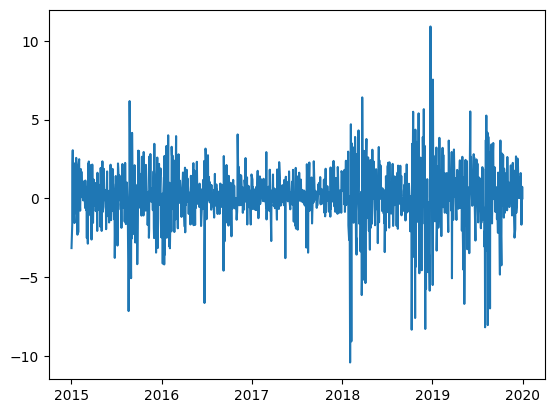

In [13]:
plt.plot(tickerDf.FirstDifference)
plt.show()

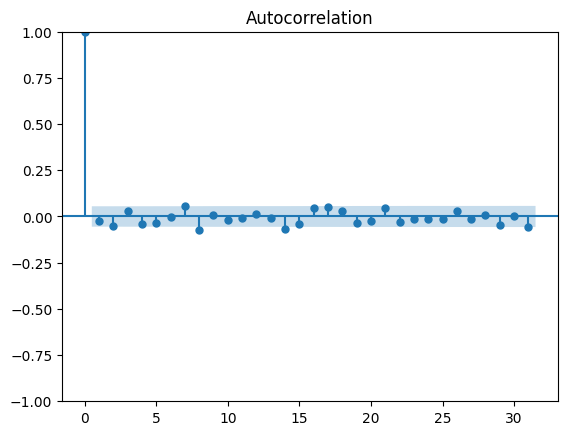

In [14]:
acf_plot = plot_acf(tickerDf.FirstDifference)

#### ACF is not helpful

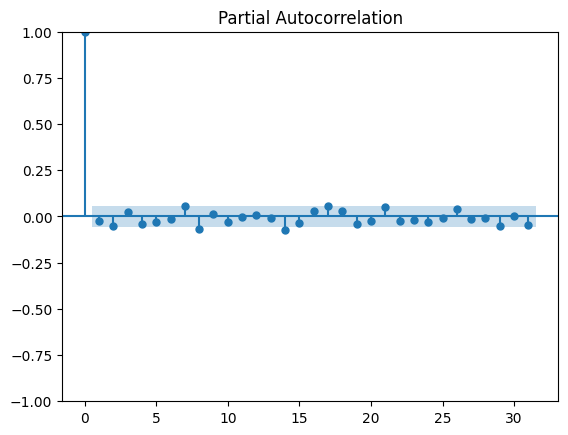

In [15]:
pacf_plot = plot_pacf(tickerDf.FirstDifference)

#### This is also not that much helpful, which tells that stock price prediction is not an easy process

# Augmented Dickey Fuller Test

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def generate_ar_process(lags, coefs, length):
    
    #cast coefs to np array
    coefs = np.array(coefs)
    
    #initial values
    series = [np.random.normal() for _ in range(lags)]
    
    for _ in range(length):
        #get previous values of the series, reversed
        prev_vals = series[-lags:][::-1]
        
        #get new value of time series
        new_val = np.sum(np.array(prev_vals) * coefs) + np.random.normal()
        
        series.append(new_val)
        
    return np.array(series)

In [18]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF statistic : %f' % result[0])
    print('p-value : %f' % result[1])

# AR(1) Process

#### Stationary

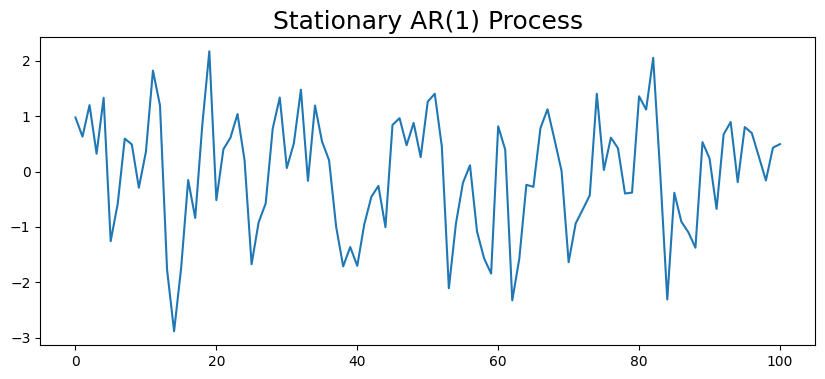

In [19]:
ar_1_process = generate_ar_process(1, [.5], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process)
plt.title('Stationary AR(1) Process', fontsize=18)
plt.show()

In [20]:
perform_adf_test(ar_1_process)

ADF statistic : -6.465542
p-value : 0.000000


#### Non-stationary

Text(0.5, 1.0, 'Non-Stationary AR(1) Process')

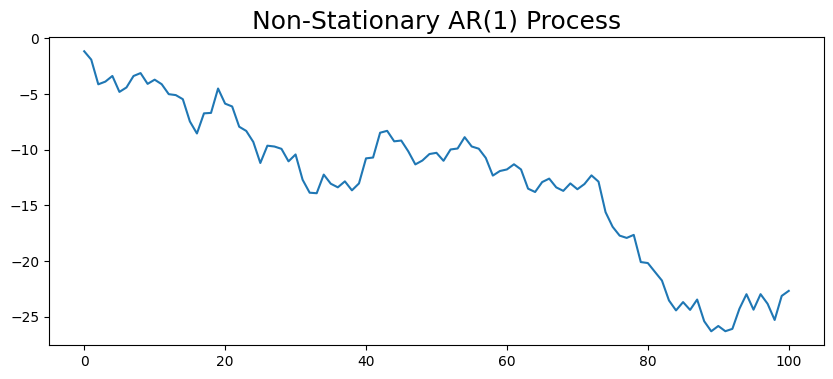

In [21]:
ar_1_process_unit_root = generate_ar_process(1, [1], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process_unit_root)
plt.title('Non-Stationary AR(1) Process', fontsize=18)

In [22]:
perform_adf_test(ar_1_process_unit_root)

ADF statistic : -1.096160
p-value : 0.716601


# AR(2) Process

#### Stationary

Text(0.5, 1.0, 'Stationary AR(2) Process')

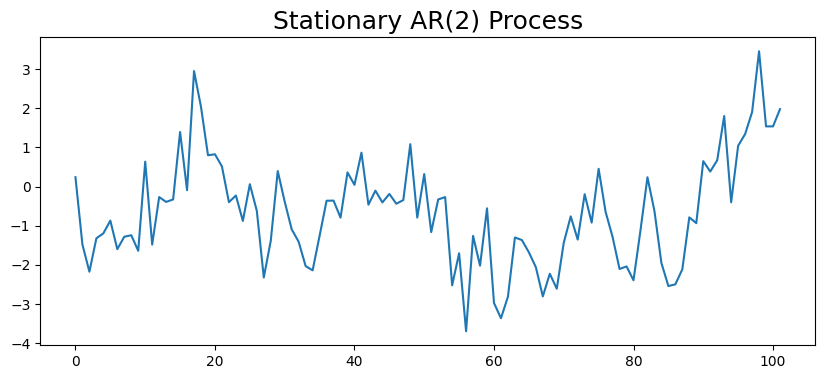

In [23]:
ar_2_process = generate_ar_process(2, [.5, .3], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_2_process)
plt.title('Stationary AR(2) Process', fontsize=18)

In [24]:
perform_adf_test(ar_2_process)

ADF statistic : -1.329582
p-value : 0.615532


#### Non-stationary

Text(0.5, 1.0, 'Non-Stationary AR(2) Process')

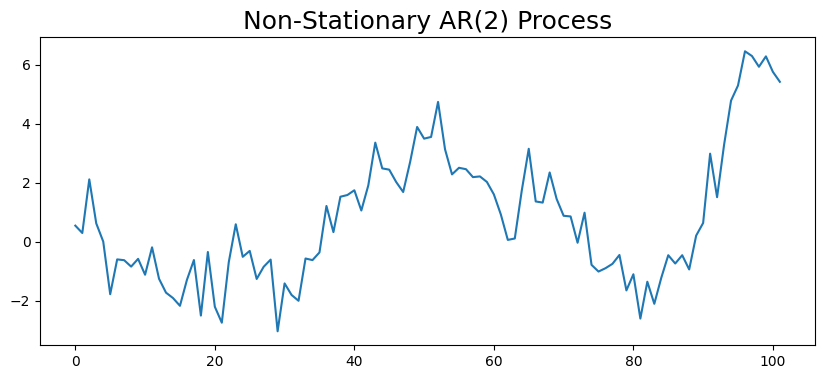

In [25]:
ar_2_process_unit_root = generate_ar_process(2, [.7, .3], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_2_process_unit_root)
plt.title('Non-Stationary AR(2) Process', fontsize=18)

In [26]:
perform_adf_test(ar_2_process_unit_root)

ADF statistic : -1.073029
p-value : 0.725707


# AR Model